In [7]:

import sys
import matplotlib.pyplot as plt
import numpy as np

# sampling freq
fs=40000
fsig=15000

#Pulse duty cycle - 40-80Hz



In [8]:
#Filtering Function

def filterSignal(sensors):
    # Initialize
    sensorsOnFiltOne=[]
    sensorsOnFiltTwo=[]
    sensorsOutput=[]

    # loop across all for sensors

    for ind in range(0,len(sensors)):
        sensorData = sensors[ind]
        # initialize filter 1 & filter 2
        crossFiltrd = np.zeros(len(sensorData)-tsLen)
        crossFiltrd2 = np.zeros(int((len(crossFiltrd)-20)/10)+1)
        
        # Filter 1 - Dot product between sensor data & template signal 
        for i in range(0,len(sensorData)-tsLen):
            crossFiltrd[i]=(np.dot(sensorData[i:i+tsLen],ts))
        sensorsOnFiltOne.append(crossFiltrd)

        # collect min , max, pos of min , pos of max & standard deviation
        sensorMin = np.min(crossFiltrd)
        sensorArgmin = np.argmin(crossFiltrd)
        sensorMax = np.max(crossFiltrd)
        sensorArgmax = np.argmax(crossFiltrd)
        sensorStd = np.std(crossFiltrd)
        
        # Output direction,  raw magnitude at corresponding time, detection value of filter one
        direction=1
        magnitude=0
        if abs(sensorMin) > sensorMax:
            direction=-1
            detectOne=(abs(sensorMin) - abs(sensorMax))/sensorStd
            magnitude = np.min(sensorData[sensorArgmin:sensorArgmin+tsLen])
            pkTime=sensorArgmin
        else:
            direction=1
            detectOne=(abs(sensorMax) - abs(sensorMin))/sensorStd
            magnitude = np.max(sensorData[sensorArgmax:sensorArgmax+tsLen])
            pkTime=sensorArgmax
        


        # Filter 2 - (Optional Filter)
        # step 1: take absolute value of the data
        # step 2: (max - mean) / standard deviation with rolling window size
        # step 3: apply (max-mean)/std. dev again to step 2 result
        # window size from 20, each step increase 10, i.e. 20, 30, 40, 50....
        k = 0
        for windowSize in range(20,len(crossFiltrd),10):
            crossFiltrd2[k]=(np.max(abs(crossFiltrd[0:windowSize]))-np.mean(abs(crossFiltrd[0:windowSize])))/np.std(abs(crossFiltrd[0:windowSize]))
            k += 1 
        sensorsOnFiltTwo.append(crossFiltrd2[1:]-crossFiltrd2[:-1]) 
        sensorsOnFiltTwo[ind]=(sensorsOnFiltTwo[ind]-np.mean(sensorsOnFiltTwo[ind]))/np.std(sensorsOnFiltTwo[ind])
        # output detect value for filter two
        detectTwo = np.max(sensorsOnFiltTwo)
        # final determination - if detectOne > threshold, count as valid measurement. 
        # For noisy measurements,
        # (i.e. mean of abs of raw data is larger than a value), 
        # if detectOne < threshold, also check if detectTwo > threshold. 
        # if detectTwo < threshold, 
        # also check if other sensors are aligned.

        # Threshold set at 3 for filter One, Threshold set at 8 for filter two
        
        validity= True if detectOne > 3 or detectTwo > 8 else False
        sensorsOutput.append([validity, magnitude*direction, detectOne, detectTwo, pkTime, direction, magnitude])
    return sensorsOutput, sensorsOnFiltOne, sensorsOnFiltTwo

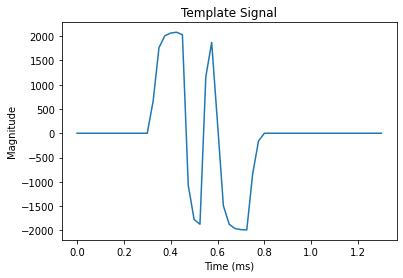

**** PROCESSING FILE : area_sensor_no_boundary1.bin ****


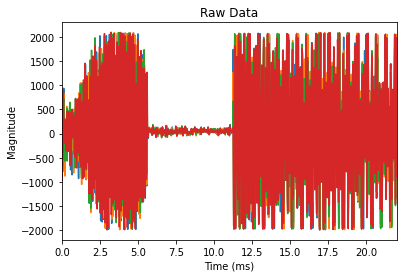

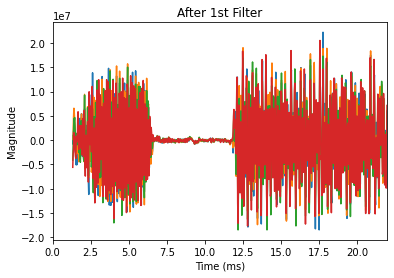

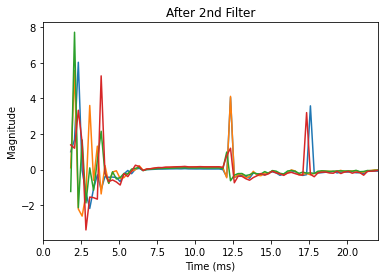

Sensor 0, No Signal Detected!

Value: 2090, Detect1: 0.58, Detect2: 6.03, Peak Pos (1/40KHz):657

Sensor 1, No Signal Detected!

Value: 2071, Detect1: 0.25, Detect2: 6.03, Peak Pos (1/40KHz):447

Sensor 2, No Signal Detected!

Value: 1972, Detect1: 0.19, Detect2: 7.72, Peak Pos (1/40KHz):434

Sensor 3, No Signal Detected!

Value: 2081, Detect1: 0.44, Detect2: 7.72, Peak Pos (1/40KHz):649

**** PROCESSING FILE : run.bin ****


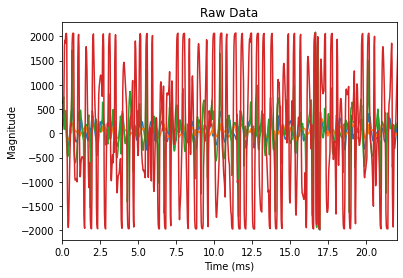

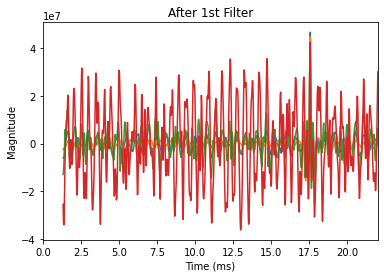

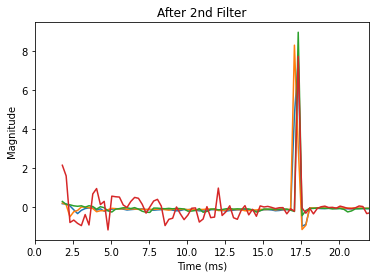

Sensor 0, Boundary Wire Signal is detected!

Value: 2083, Detect1: 7.04, Detect2: 7.50, Peak Pos (1/40KHz):649

Sensor 1, Boundary Wire Signal is detected!

Value: 2077, Detect1: 7.67, Detect2: 8.29, Peak Pos (1/40KHz):649

Sensor 2, Boundary Wire Signal is detected!

Value: 2068, Detect1: 3.70, Detect2: 8.95, Peak Pos (1/40KHz):648

Sensor 3, Boundary Wire Signal is detected!

Value: 2069, Detect1: 0.39, Detect2: 8.95, Peak Pos (1/40KHz):648

**** PROCESSING FILE : statics.bin ****


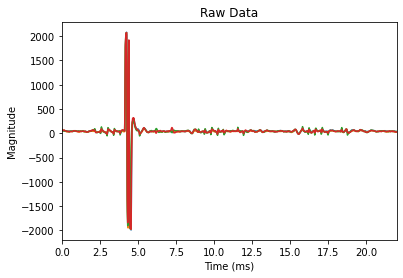

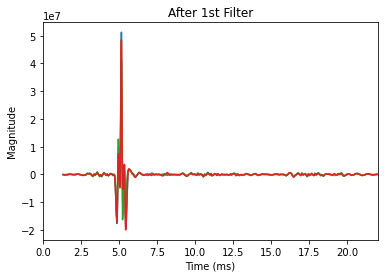

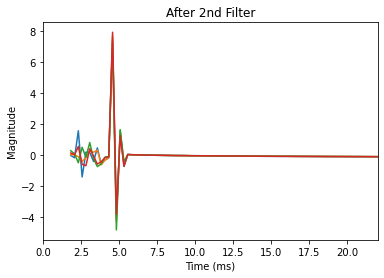

Sensor 0, Boundary Wire Signal is detected!

Value: 2081, Detect1: 10.11, Detect2: 7.52, Peak Pos (1/40KHz):153

Sensor 1, Boundary Wire Signal is detected!

Value: 2073, Detect1: 9.86, Detect2: 7.72, Peak Pos (1/40KHz):153

Sensor 2, Boundary Wire Signal is detected!

Value: 2066, Detect1: 9.04, Detect2: 7.72, Peak Pos (1/40KHz):153

Sensor 3, Boundary Wire Signal is detected!

Value: 2073, Detect1: 9.25, Detect2: 7.95, Peak Pos (1/40KHz):153



In [9]:

#40-80Hz
# template signal
ts=[]
try:

    # Load template signal (size of 53)
    with open(".\\template\\template1.txt","r") as f:
        while True:
            line = f.readline()
            if line:
                ts.append(int(line))
            else:
                break
    tsLen = len(ts)
    
    fig1=plt.figure()
    plt.title("Template Signal")
    plt.ylabel("Magnitude")
    plt.xlabel("Time (ms)")
    plt.plot(np.arange(0,tsLen)/fs*1000,ts)
    plt.show()

    # Load all signals
    files=["area_sensor_no_boundary1", "run", "statics"]
    
    for filename in files:
        # Load bin file
        with open(".\\signal\\"+filename+".bin", "rb") as f:
            sensorInd=0
            sensors=[]
            for i in range(1,5):
                sensorData=[]
                sensors.append(sensorData)
            while True:
                # Read every 2 byte
                byte = f.read(2)
                if byte:
                    if sensorInd>=3:
                        sensors[sensorInd].append(int.from_bytes(byte, byteorder='little')-2000)
                        sensorInd=0
                    else:
                        sensors[sensorInd].append(int.from_bytes(byte, byteorder='little')-2000)
                        sensorInd+=1
                else:
                    break

        #filter the signal

        sensorsOutput,sensorsOnFiltOne, sensorsOnFiltTwo=filterSignal(sensors)

        
        print("**** PROCESSING FILE : {0}.bin ****".format(filename))

        ## Plot Data
        t=np.linspace(0,len(sensors[0])/fs*1000,len(sensors[0]))

        fig1=plt.figure()
        plt.title("Raw Data")
        plt.ylabel("Magnitude")
        plt.xlabel("Time (ms)")
        plt.xlim(0,22)
        plt.plot(t,sensors[0])
        plt.plot(t,sensors[1])
        plt.plot(t,sensors[2])
        plt.plot(t,sensors[3])  

        fig1=plt.figure()
        plt.title("After 1st Filter")
        plt.ylabel("Magnitude")
        plt.xlabel("Time (ms)")
        plt.xlim(0,22)
        plt.plot(t[len(sensors[0])-len(sensorsOnFiltOne[0]):],sensorsOnFiltOne[0])
        plt.plot(t[len(sensors[0])-len(sensorsOnFiltOne[0]):],sensorsOnFiltOne[1])
        plt.plot(t[len(sensors[0])-len(sensorsOnFiltOne[0]):],sensorsOnFiltOne[2])
        plt.plot(t[len(sensors[0])-len(sensorsOnFiltOne[0]):],sensorsOnFiltOne[3])

        fig2=plt.figure()
        plt.title("After 2nd Filter")
        plt.ylabel("Magnitude")
        plt.xlabel("Time (ms)")
        plt.xlim(0,22)
        nt=np.arange(20+len(sensors[0])-len(sensorsOnFiltOne[0]),len(sensors[0]),10)/fs*1000
        plt.plot(nt[:-1],sensorsOnFiltTwo[0])
        plt.plot(nt[:-1],sensorsOnFiltTwo[1])
        plt.plot(nt[:-1],sensorsOnFiltTwo[2])
        plt.plot(nt[:-1],sensorsOnFiltTwo[3])
        plt.show()


        # Even if filter one or filter two fails, Check if the peak position is aligned with other sensors. If aligned then signal is still valid.
        for j in range(0,len(sensorsOutput)):
            if not sensorsOutput[j][0]:
                accumPkTimeDiff=0
                for z in range(0,len(sensorsOutput)):
                    if j != z:
                        accumPkTimeDiff+=abs(sensorsOutput[j][4]-sensorsOutput[z][4])
                if accumPkTimeDiff < 4:
                    sensorsOutput[j][0]=True
                    print("Detected an Alignment with other sensors")
            


            if sensorsOutput[j][0]:
                print("Sensor {1}, Boundary Wire Signal is detected!\n".format(filename, j))
            else:
                print("Sensor {1}, No Signal Detected!\n".format(filename, j))
            print("Value: {0}, Detect1: {1:.2f}, Detect2: {2:.2f}, Peak Pos (1/40KHz):{3}\n".format(sensorsOutput[j][1],sensorsOutput[j][2],sensorsOutput[j][3],sensorsOutput[j][4]))
            

except IOError:
     print('Error While Opening the file!')  

